In [8]:
import os
import cv2
import numpy as np


In [ ]:
import os
import cv2
import numpy as np

input_folder = "masks" 
output_folder = "masks_gray_2"  
os.makedirs(output_folder, exist_ok=True)

class_rgb = {
    (0, 255, 255): 0,    # Urban Land
    (255, 255, 0): 1,    # Agriculture Land
    (255, 0, 255): 2,    # Rangeland
    (0, 255, 0): 3,      # Forest Land
    (0, 0, 255): 4,      # Water
    (255, 255, 255): 5,  # Barren Land
    (0, 0, 0): 6         # Unknown
}
#----------------------------------------------------------
# Convertir RGB e Indices de classes
def convert_rgb_to_class_index(mask_rgb):
    mask_gray = np.full(mask_rgb.shape[:2], 255, dtype=np.uint8)  # Valeur par défaut (255 = inconnu)
    for rgb, class_index in class_rgb.items():
        mask_gray[np.all(mask_rgb == rgb, axis=-1)] = class_index
    return mask_gray

# Parcourir tous les fichiers du dossier
for filename in os.listdir(input_folder):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        img_path = os.path.join(input_folder, filename)
        

        mask_rgb = cv2.imread(img_path)  
        mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB) 
        
        
        mask_gray = convert_rgb_to_class_index(mask_rgb)
        
        #
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, mask_gray)

print("✅ Conversion terminée ! Tous les masques sont dans", output_folder)


✅ Conversion terminée ! Tous les masques sont dans masks_gray_2


In [3]:

#test 
import cv2
import numpy as np
import os

mask_folder = "D:/Documents/telechargement/dubai_2/masks_256"  # Dossier des masques indexés

gray_values = set()

for filename in os.listdir(mask_folder):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        mask = cv2.imread(os.path.join(mask_folder, filename), cv2.IMREAD_GRAYSCALE)
        unique_values = np.unique(mask)
        gray_values.update(unique_values)

print("Valeurs uniques trouvées dans les masques :", sorted(gray_values))


Valeurs uniques trouvées dans les masques : [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5)]


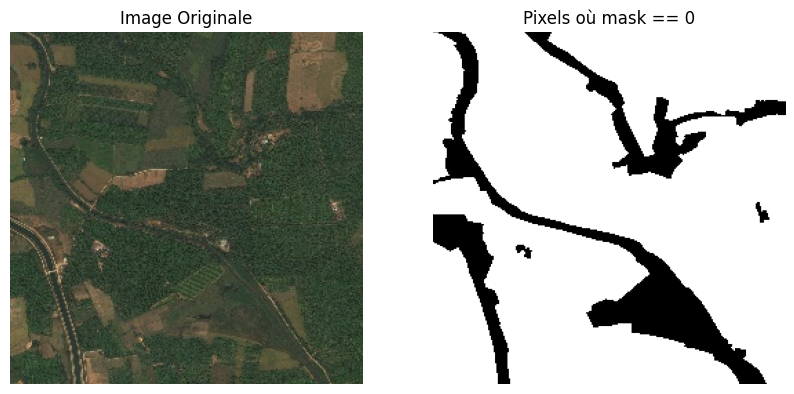

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


image_path = "images_resized/119_sat.jpg" 
mask_path = "masks_resized/119_mask.png"  
image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Créer une image binaire où 0 = blanc et les autres classes = noir
zero_mask = (mask == 1).astype(np.uint8) * 255  


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  
plt.title("Image Originale")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(zero_mask, cmap="gray")
plt.title("Pixels où mask == 0")
plt.axis("off")

plt.show()

In [ ]:
import os
import cv2
import numpy as np

# pour decouper les images et masks 

input_images_dir = "images"  
input_masks_dir = "masks_gray_2"  
output_images_dir = "images_256" 
output_masks_dir = "masks_256" 

os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_masks_dir, exist_ok=True)

def split_image_and_mask(image_path, mask_path, output_images_dir, output_masks_dir, patch_size=256):
    img = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 

    if img is None or mask is None:
        print(f"⚠️ Erreur lors de la lecture de {image_path} ou {mask_path}")
        return
    
    h, w, _ = img.shape  
    
    patch_id = 0
    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            img_patch = img[y:y+patch_size, x:x+patch_size] 
            mask_patch = mask[y:y+patch_size, x:x+patch_size] 

            if img_patch.shape[:2] == (patch_size, patch_size) and mask_patch.shape[:2] == (patch_size, patch_size):
                base_name = os.path.basename(image_path).split('.')[0]
                img_patch_name = f"{base_name}_{patch_id}.png"
                mask_patch_name = f"{base_name}_{patch_id}.png"

                cv2.imwrite(os.path.join(output_images_dir, img_patch_name), img_patch)
                cv2.imwrite(os.path.join(output_masks_dir, mask_patch_name), mask_patch)

                patch_id += 1

image_filenames = sorted(os.listdir(input_images_dir))
mask_filenames = sorted(os.listdir(input_masks_dir))

for img_filename, mask_filename in zip(image_filenames, mask_filenames):
    img_path = os.path.join(input_images_dir, img_filename)
    mask_path = os.path.join(input_masks_dir, mask_filename)
    split_image_and_mask(img_path, mask_path, output_images_dir, output_masks_dir)

print("✅ Découpage terminé !")
print(f"📂 Images découpées dans : {output_images_dir}")
print(f"📂 Masques découpés dans : {output_masks_dir}")


✅ Découpage terminé !
📂 Images découpées dans : images_256
📂 Masques découpés dans : masks_256


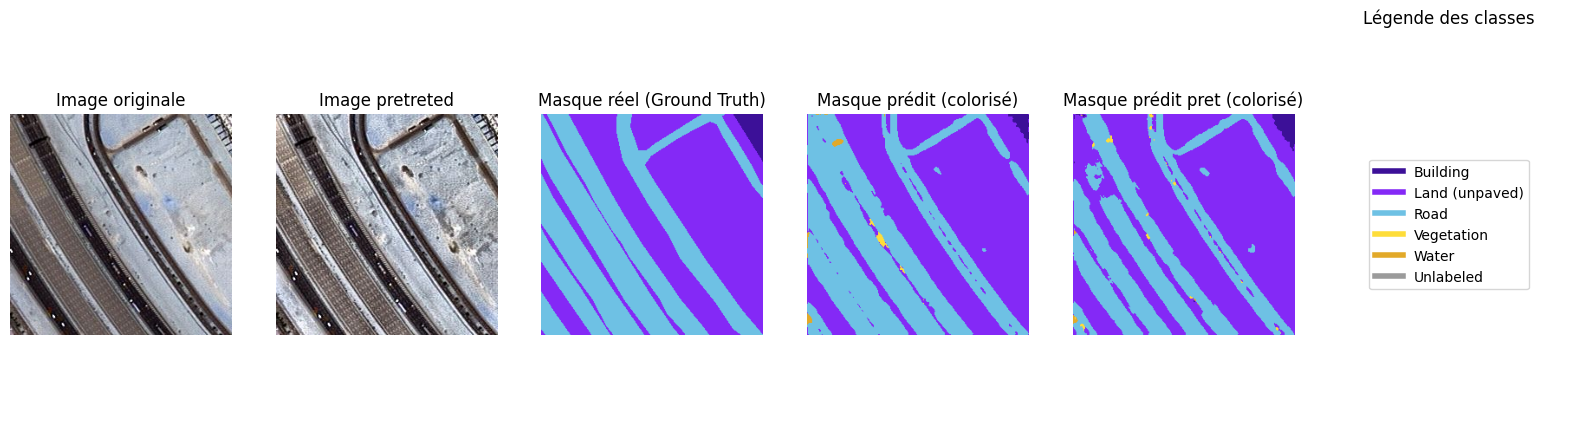

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from unet import UNet  

# ======================== 1. Charger le modèle ========================= #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=6).to(device)  
model.load_state_dict(torch.load("D:/Documents/telechargement/dubai_2/best2_unet_model_dubai.pth", map_location=device))
model.eval()
#D:/Documents/telechargement/dubai_2/
# ======================== 2. Définir le mapping exact des classes ========================= #
class_rgb = {
    1: ((60, 16, 152), "Building"),       # Bâtiment
    2: ((132, 41, 246), "Land (unpaved)"), # Sol non pavé
    3: ((110, 193, 228), "Road"),         # Route
    4: ((254, 221, 58), "Vegetation"),    # Végétation
    5: ((226, 169, 41), "Water"),         # Eau
    0: ((155, 155, 155), "Unlabeled")     # Non étiqueté
}

# ======================== 3. Fonction de prédiction ========================= #
def predict(image_path):
    # prétraiter l'image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalisation [0,1]
    image = cv2.resize(image, (256, 256)) 
    image = np.transpose(image, (2, 0, 1)) 
    
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)


    with torch.no_grad():
        output = model(image_tensor)
    
    predicted_mask = torch.argmax(output, dim=1).cpu().numpy()[0]

    return predicted_mask

# ======================== 4. Coloriser le masque ========================= #
def colorize_mask(mask):
    height, width = mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)

    for class_idx, (rgb, _) in class_rgb.items():
        color_mask[mask == class_idx] = rgb  

    return color_mask

# ======================== 5. Charger le masque réel ========================= #
def load_true_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))  
    return colorize_mask(mask)  

# ======================== 6. Tester une image ========================= #
image_path = "D:/Documents/telechargement/dubai_2/images_add/Tile7_image_part_001_10.png"
image_path_pret = "D:/Documents/telechargement/dubai_2/images_add/Tile7_image_part_001_10_p.tif" 
mask_path = "D:/Documents/telechargement/dubai_2/masks_256/Tile7_image_part_001_10.png"

predicted_mask = predict(image_path)
predicted_mask_pret = predict(image_path_pret)
colorized_mask = colorize_mask(predicted_mask)
colorized_mask_pret = colorize_mask(predicted_mask_pret)
true_mask = load_true_mask(mask_path)

# ======================== 7. Afficher les résultats ========================= #
fig, axes = plt.subplots(1, 6, figsize=(20, 5))

axes[0].imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
axes[0].set_title("Image originale")
axes[0].axis("off")
axes[1].imshow(cv2.cvtColor(cv2.imread(image_path_pret), cv2.COLOR_BGR2RGB))
axes[1].set_title("Image pretreted")
axes[1].axis("off")
axes[2].imshow(true_mask)
axes[2].set_title("Masque réel (Ground Truth)")
axes[2].axis("off")

axes[3].imshow(colorized_mask)
axes[3].set_title("Masque prédit (colorisé)")
axes[3].axis("off")

axes[4].imshow(colorized_mask_pret)
axes[4].set_title("Masque prédit pret (colorisé)")
axes[4].axis("off")

legend_patches = [plt.Line2D([0], [0], color=np.array(rgb)/255, lw=4, label=f"{name}") 
                  for _, (rgb, name) in class_rgb.items()]
axes[5].legend(handles=legend_patches, loc="center", fontsize=10)
axes[5].set_title("Légende des classes")
axes[5].axis("off")

plt.show()


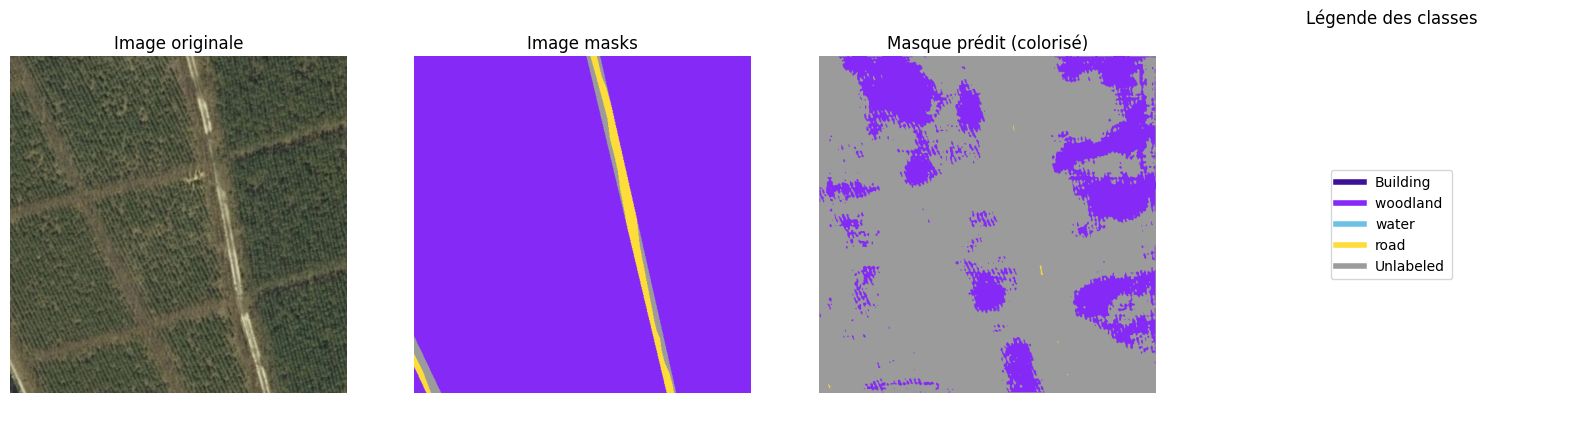

In [4]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from unet import UNet  

# ======================== 1. Charger le modèle ========================= #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=5).to(device)  
model.load_state_dict(torch.load("D:/Documents/telechargement/landcoverv2/best_unet_model_land.pth", map_location=device))
model.eval()

# ======================== 2. Définir le mapping exact des classes ========================= #
class_rgb = {
    1: ((60, 16, 152), "Building"),       # Bâtiment
    2: ((132, 41, 246), "woodland "),
    3: ((110, 193, 228), "water"),       
    4: ((254, 221, 58), "road"),   
    0: ((155, 155, 155), "Unlabeled")    
}

# ======================== 3. Fonction de prédiction ========================= #
def predict(image_path):
    # prétraiter l'image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalisation [0,1]
    image = cv2.resize(image, (512, 512)) 
    image = np.transpose(image, (2, 0, 1)) 
    
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)


    with torch.no_grad():
        output = model(image_tensor)
    
    predicted_mask = torch.argmax(output, dim=1).cpu().numpy()[0]

    return predicted_mask

# ======================== 4. Coloriser le masque ========================= #
def colorize_mask(mask):
    height, width = mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)

    for class_idx, (rgb, _) in class_rgb.items():
        color_mask[mask == class_idx] = rgb  

    return color_mask

# ======================== 5. Charger le masque réel ========================= #
def load_true_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (512, 512))  
    return colorize_mask(mask)  

# ======================== 6. Tester une image ========================= #
image_path = "D:/Documents/telechargement/landcoverv2/images_1_3k/M-33-7-A-d-2-3_7.jpg"
mask_path = "D:/Documents/telechargement/landcoverv2/masks_1_3k/M-33-7-A-d-2-3_7_m.png"

predicted_mask = predict(image_path)
colorized_mask = colorize_mask(predicted_mask)
true_mask = load_true_mask(mask_path)

# ======================== 7. Afficher les résultats ========================= #
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
axes[0].set_title("Image originale")
axes[0].axis("off")
axes[1].imshow(true_mask)
axes[1].set_title("Image masks")
axes[1].axis("off")

axes[2].imshow(colorized_mask)
axes[2].set_title("Masque prédit (colorisé)")
axes[2].axis("off")


legend_patches = [plt.Line2D([0], [0], color=np.array(rgb)/255, lw=4, label=f"{name}") 
                  for _, (rgb, name) in class_rgb.items()]
axes[3].legend(handles=legend_patches, loc="center", fontsize=10)
axes[3].set_title("Légende des classes")
axes[3].axis("off")

plt.show()


In [ ]:
import os
import cv2
import glob


#meilleure ?

IMG_DIR = "D:/Documents/telechargement/dubai_2/images_256"

OUT_IMG_DIR = "D:/Documents/telechargement/dubai_2/images_pret_2"

os.makedirs(OUT_IMG_DIR, exist_ok=True)

img_paths = sorted(glob.glob(os.path.join(IMG_DIR, "*.png")))

for img_path in img_paths:
    img_name = os.path.splitext(os.path.basename(img_path))[0]

    img = cv2.imread(img_path)

    # Appliquer CLAHE (amélioration du contraste adaptatif)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)


    out_img_path = os.path.join(OUT_IMG_DIR, f"{img_name}_p.tif")

    cv2.imwrite(out_img_path, enhanced_img)


In [11]:
import os
import cv2
import glob

IMG_DIR = "D:/Documents/telechargement/dubai_2/images_pret_2"
MASK_DIR = "D:/Documents/telechargement/dubai_2/masks_256"

OUT_IMG_DIR = "D:/Documents/telechargement/dubai_2/images_p"
OUT_MASK_DIR = "D:/Documents/telechargement/dubai_2/masques_p"

os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs(OUT_MASK_DIR, exist_ok=True)

img_paths = sorted(glob.glob(os.path.join(IMG_DIR, "*.tif")))
mask_paths = sorted(glob.glob(os.path.join(MASK_DIR, "*.png")))

for img_path, mask_path in zip(img_paths, mask_paths):
    img_name = os.path.splitext(os.path.basename(img_path))[0]
    mask_name = os.path.splitext(os.path.basename(mask_path))[0]

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

    out_img_path = os.path.join(OUT_IMG_DIR, f"{img_name}_p.png")
    out_mask_path = os.path.join(OUT_MASK_DIR, f"{mask_name}_p.png")

    cv2.imwrite(out_img_path, img)
    cv2.imwrite(out_mask_path, mask)


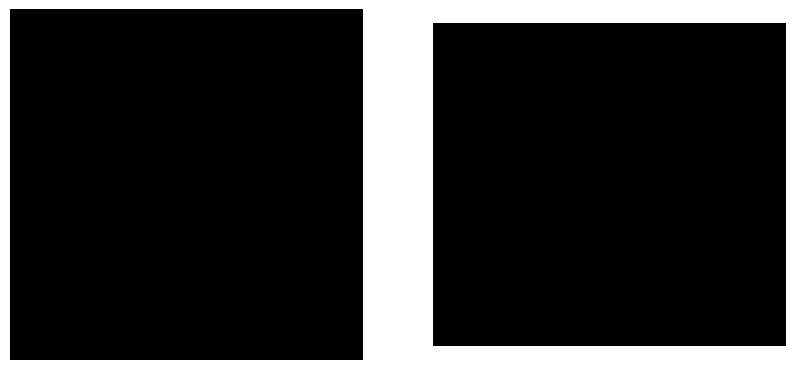

In [28]:
import cv2
import matplotlib.pyplot as plt

image_path1 = 'D:/Documents/telechargement/cds/napoli/Napoli_119901_20161029_2A_MS/IMAGERY.tif'
image_path2 = 'D:/Documents/telechargement/cds/dubai/Dubai1_119874_20161029_2A_MS/IMAGERY.tif'

image1 = cv2.imread(image_path1, cv2.IMREAD_COLOR)
image2 = cv2.imread(image_path2, cv2.IMREAD_COLOR)

image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image2_rgb)
plt.axis('off')

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..1023].


Shape: (4, 2098, 2094)


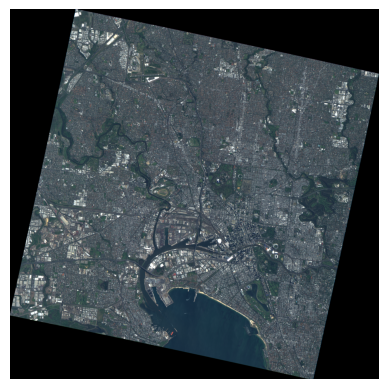

C:\Users\meriem\AppData\Local\Temp\ipykernel_16088\710712448.py:17: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave("image_convertie4.tif", img_rgb)


True

In [ ]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import cv2

img = tiff.imread("D:/Documents/telechargement/cds/Malbourne_117896_20161019_2A_MS/IMAGERY.tif")
print("Shape:", img.shape) 

img = np.transpose(img, (1, 2, 0))  


img_rgb = img[:, :, :3]
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

#tiff.imsave("image_convertie4.tif", img_rgb)
cv2.imwrite("image_convertie_4.jpg", cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))


In [7]:
from PIL import Image

img = Image.open("image_convertie_4.jpg")

# Recadrage manuel : crop(left, upper, right, lower)
#img_crop = img.crop((30, 25, img.width - 25, img.height - 20))

#img_crop.save("image_recadree_manuellement.jpg")
img.save("image_convertie_4.tif")

In [11]:
from PIL import Image

# 
img = Image.open("image_convertie_4.tif")


img = img.rotate(12.1, expand=True)


gray = img.convert("L")


bbox = gray.getbbox()

if bbox:
 
    img_cropped = img.crop(bbox)
    img_cropped.save("image_crop_auto.tif")
    print("Image rognée et sauvegardée.")
else:
    print("Image entièrement noire.")


Image rognée et sauvegardée.


In [12]:
from PIL import Image

img = Image.open("image_crop_auto.tif")

# Recadrage manuel : crop(left, upper, right, lower)
img_crop = img.crop((30, 25, img.width - 25, img.height - 20))

img_crop.save("image_recadree_manuellement.jpg")
img_crop.save("image_recadree_manuellement.tif")


In [ ]:
from PIL import Image
import numpy as np

image = Image.open("D:/Documents/telechargement/dubai_2/images_256/Tile8_image_part_007_20.png")

image_array = np.array(image)
print("Shape:", image_array.shape)



In [ ]:
import os
import random
import shutil


images_dir = "D:/Documents/telechargement/landcoverv2/images_512"
masks_dir = "D:/Documents/telechargement/landcoverv2/masks_512"

dest_images_dir = "D:/Documents/telechargement/landcoverv2/images_1_3k"
dest_masks_dir = "D:/Documents/telechargement/landcoverv2/masks_1_3k"
os.makedirs(dest_images_dir, exist_ok=True)
os.makedirs(dest_masks_dir, exist_ok=True)


all_images = [f for f in os.listdir(images_dir) if f.endswith(".jpg")]

valid_images = [f for f in all_images if os.path.exists(os.path.join(masks_dir, f.split('.')[0] + "_m.png"))]


print(f"Nombre de paires valides trouvées : {len(valid_images)}")


assert len(valid_images) >= 1300, "Pas assez de paires image/masque."

s
selected = random.sample(valid_images, 1300)


for filename in selected:
    mask_name = filename.split('.')[0] + "_m.png"  

    shutil.copyfile(os.path.join(images_dir, filename), os.path.join(dest_images_dir, filename))
    shutil.copyfile(os.path.join(masks_dir, mask_name), os.path.join(dest_masks_dir, mask_name))

print("✅ 1300 images + masques copiés avec succès.")


Nombre de paires valides trouvées : 10674
✅ 1300 images + masques copiés avec succès.


In [2]:
import os
import random
import shutil

images_path = "D:/Documents/telechargement/dubai_2/images_256"
masks_path = "D:/Documents/telechargement/dubai_2/masks_256"
test_images_dir = "D:/Documents/telechargement/dubai_2/test_images"
test_masks_dir = "D:/Documents/telechargement/dubai_2/test_masks"

os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_masks_dir, exist_ok=True)

image_filenames = sorted(os.listdir(images_path))
mask_filenames = sorted(os.listdir(masks_path))

assert len(image_filenames) == len(mask_filenames)

indices = random.sample(range(len(image_filenames)), 130)

for idx in indices:
    image_file = image_filenames[idx]
    mask_file = mask_filenames[idx]
    
    shutil.move(os.path.join(images_path, image_file), os.path.join(test_images_dir, image_file))
    shutil.move(os.path.join(masks_path, mask_file), os.path.join(test_masks_dir, mask_file))

print(f"130 images et masques ont été déplacés vers les dossiers de test.")


130 images et masques ont été déplacés vers les dossiers de test.


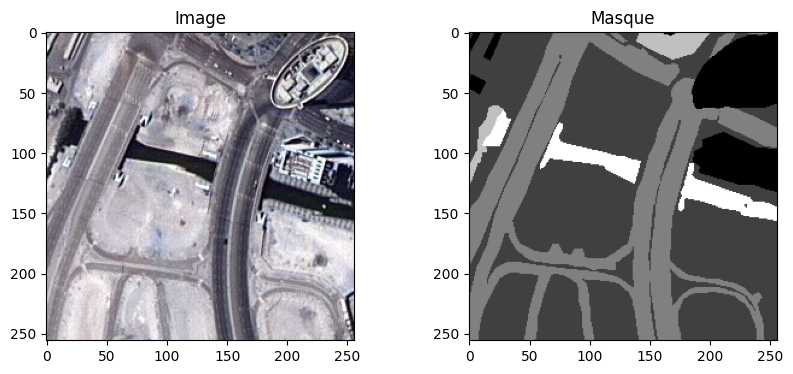

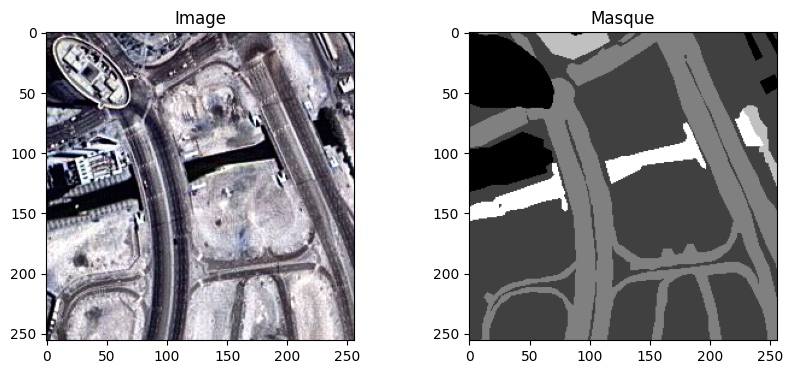

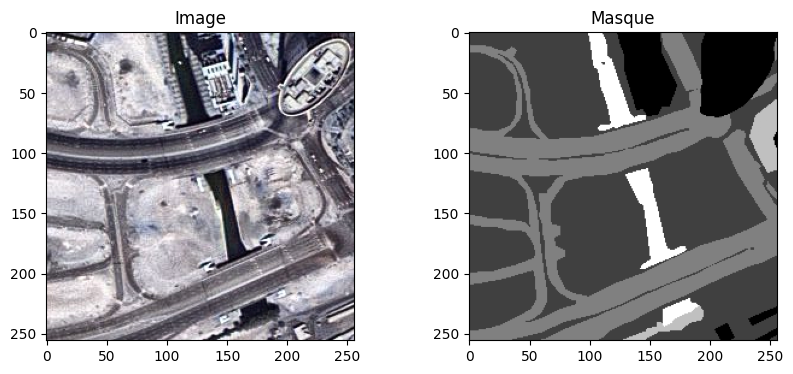

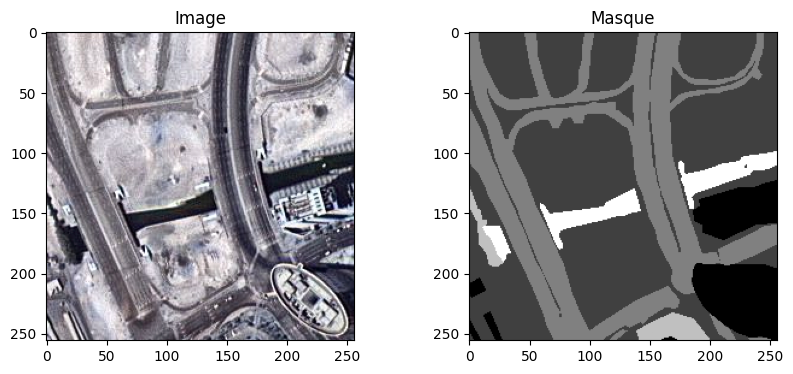

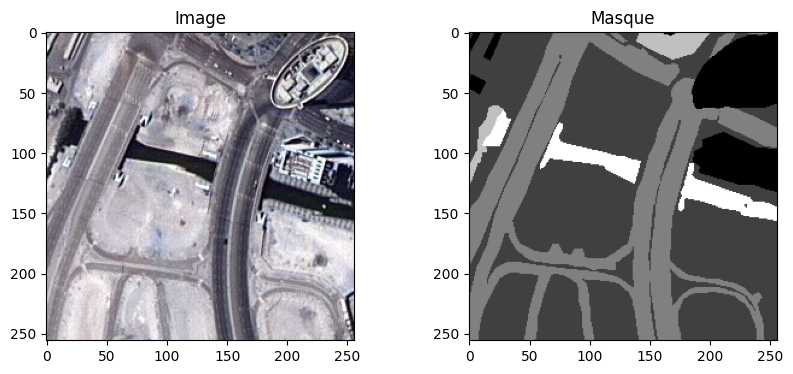

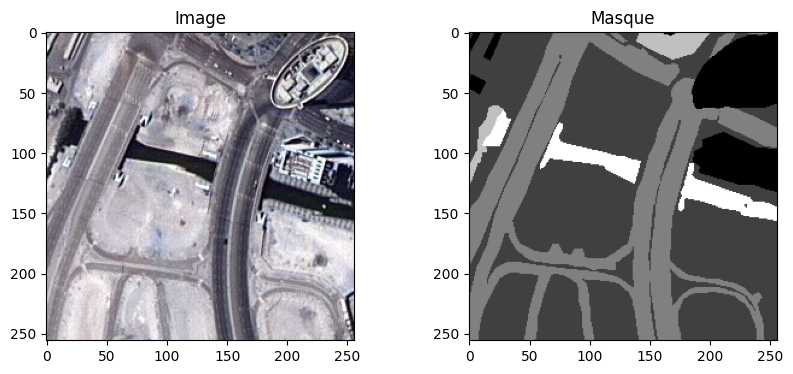

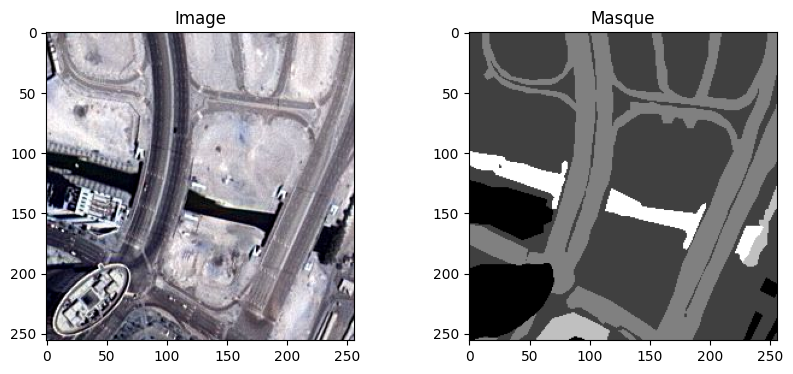

In [15]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from unet import UNet
from SatelliteDataClass import SatelliteDataset
from Metrics import SegmentationMetrics
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ======================== 2. Train / Validation Split ========================= #
images_path = "D:/Documents/telechargement/dubai_2/images_256"
masks_path = "D:/Documents/telechargement/dubai_2/masks_256"

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ElasticTransform(p=0.2, alpha=1, sigma=50),
    A.RandomBrightnessContrast(p=0.2),
    A.CLAHE(p=0.3),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
    ])

val_transform = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])


full_dataset = SatelliteDataset(images_path, masks_path)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_indices, val_indices = random_split(range(len(full_dataset)), [train_size, val_size])

train_dataset = torch.utils.data.Subset(
    SatelliteDataset(images_path, masks_path, transform=train_transform),
    train_indices
)


# Prendre 5 images aléatoires du dataset
for _ in range(7):
    image, mask = train_dataset[0]  # ou val_dataset[i]

    # Si image est tensor (C, H, W), convertir pour affichage
    img_np = image.numpy().transpose(1, 2, 0)  # (H, W, C)
    img_np = (img_np * 0.5 + 0.5).clip(0, 1)  # dé-normalisation

    # Masque en numpy (H, W)
    mask_np = mask.numpy()

    # Affichage
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap="gray")
    plt.title("Masque")

    plt.show()
